In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("life_satisfaction.csv")

In [ ]:
print(df.info())
print(df.describe(include='all'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18957 entries, 0 to 18956
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                18957 non-null  int64 
 1   A2                 18957 non-null  object
 2   C1                 18957 non-null  object
 3   D2                 18957 non-null  object
 4   D4                 18957 non-null  object
 5   D8                 18957 non-null  object
 6   D10                18957 non-null  object
 7   D15                18957 non-null  object
 8   job                18446 non-null  object
 9   F15                18957 non-null  object
 10  M8                 18957 non-null  object
 11  E17                18957 non-null  object
 12  G1                 18957 non-null  object
 13  J2                 18957 non-null  object
 14  J4                 18957 non-null  object
 15  J9                 18957 non-null  object
 16  life_satisfaction  18957 non-null  objec

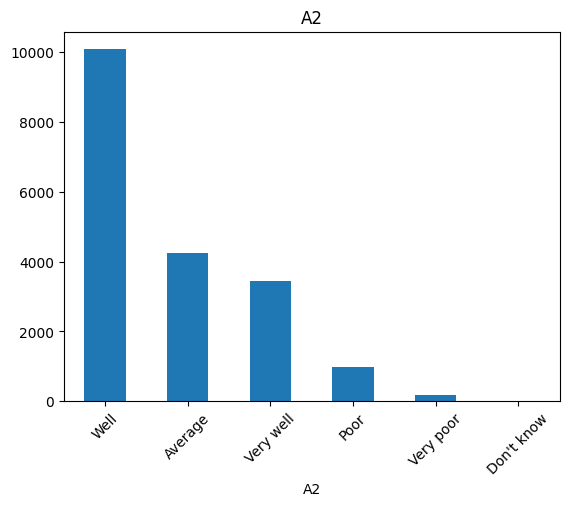

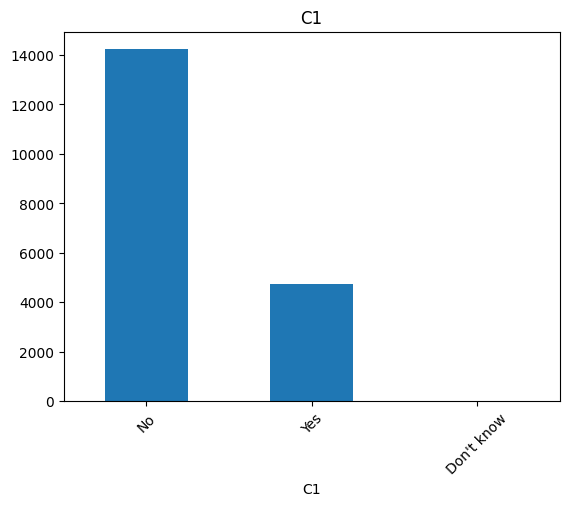

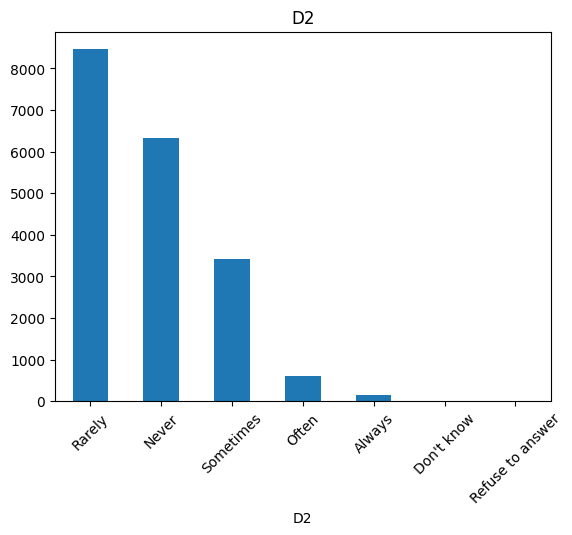

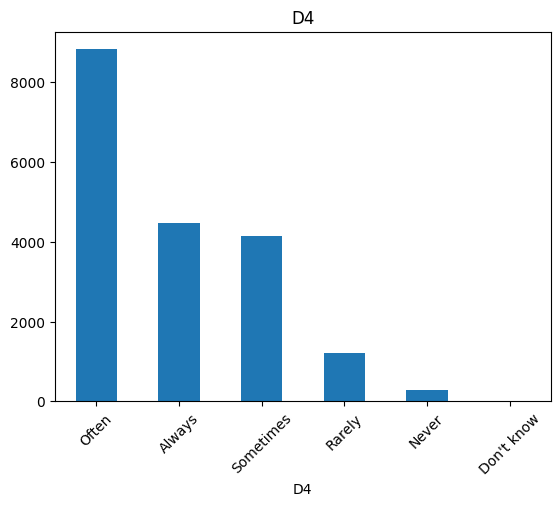

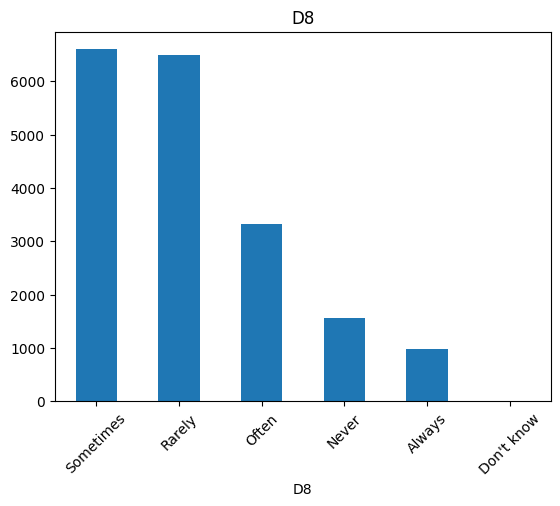

In [ ]:
categorical_features = df.select_dtypes(include='object').columns.tolist()

for col in categorical_features[:5]:  # Top 5
    df[col].value_counts().plot(kind='bar', title=col)
    plt.xticks(rotation=45)
    plt.show()


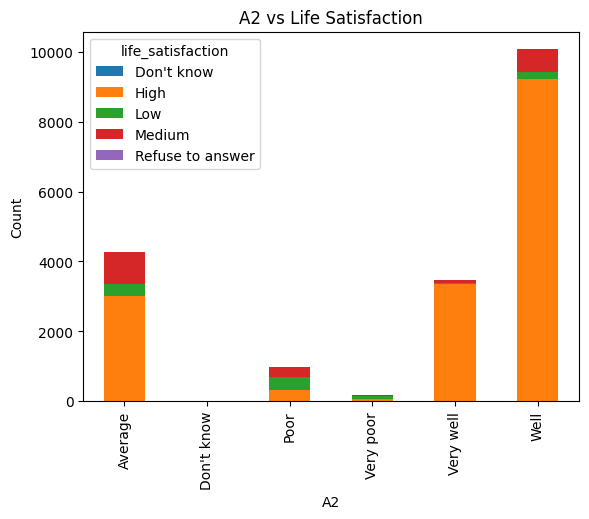

In [ ]:
pd.crosstab(df['A2'], df['life_satisfaction']).plot(kind='bar', stacked=True)
plt.title("A2 vs Life Satisfaction")
plt.ylabel("Count")
plt.show()


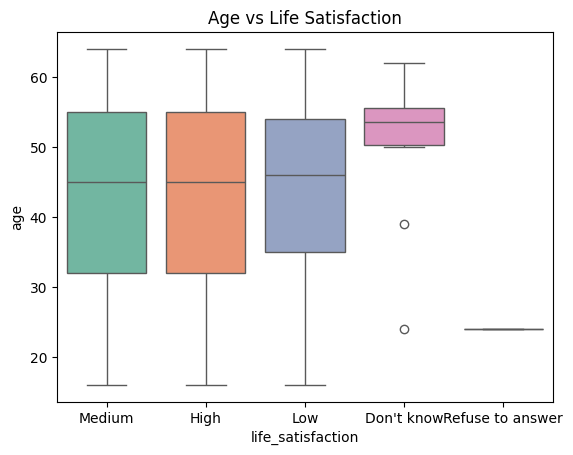

In [ ]:
sns.boxplot(data=df, x='life_satisfaction', y='age', palette='Set2')
plt.title("Age vs Life Satisfaction")
plt.show()


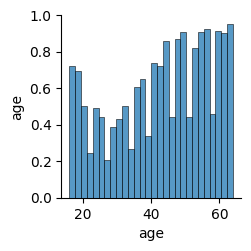

In [ ]:
numerical_features = ['age']
sns.pairplot(df[numerical_features])
plt.show()

In [ ]:
missing = df.isnull().sum()
print(missing[missing > 0])

# Simple strategy
df['job'].fillna('Unknown', inplace=True)


job    511
dtype: int64


In [ ]:
X = df.drop('life_satisfaction', axis=1)
y = df['life_satisfaction']

# Check value counts for the target variable
print(y.value_counts())

# Identify classes with only one instance and remove them
least_populated_classes = y.value_counts()[y.value_counts() < 2].index
df_filtered = df[~df['life_satisfaction'].isin(least_populated_classes)]

X_filtered = df_filtered.drop('life_satisfaction', axis=1)
y_filtered = df_filtered['life_satisfaction']

# Split the filtered data
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, stratify=y_filtered, test_size=0.2, random_state=42)

life_satisfaction
High                15943
Medium               1975
Low                  1028
Don't know             10
Refuse to answer        1
Name: count, dtype: int64


In [ ]:
categorical_features.remove('life_satisfaction')  # Remove target
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

X_encoded = preprocessor.fit_transform(X_filtered)

In [ ]:
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_encoded)

In [ ]:
sm = SMOTE(random_state=42)
tl = TomekLinks()

X_resampled, y_resampled = sm.fit_resample(X_scaled, y_filtered)
X_cleaned, y_cleaned = tl.fit_resample(X_resampled, y_resampled)

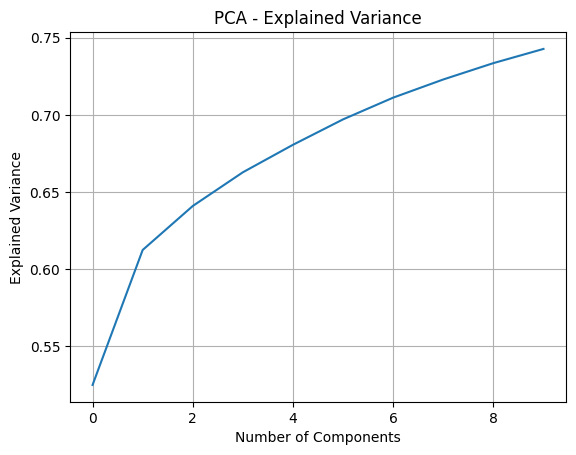

In [ ]:
# Apply PCA instead of correlation matrix for high-dim one-hot encoded data
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_cleaned)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.01, random_state=42)
outliers = iso.fit_predict(X_pca)
mask = outliers != -1
X_final, y_final = X_pca[mask], y_cleaned[mask]


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y_final)

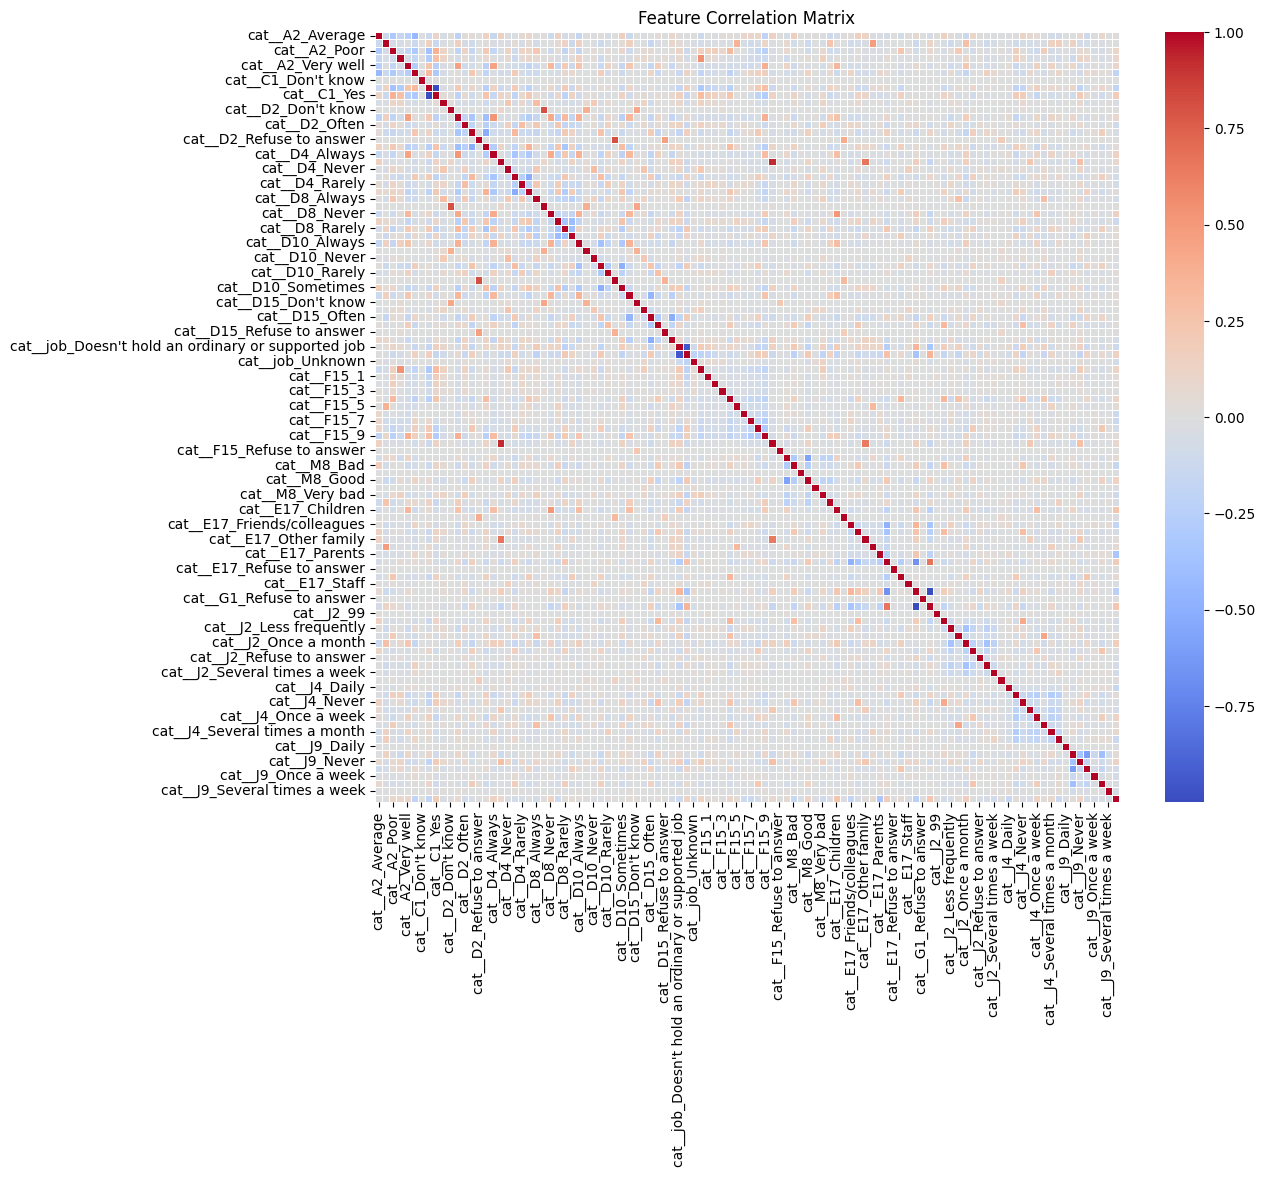

In [ ]:
feature_names = preprocessor.get_feature_names_out()

# Convert to dense if sparse
X_cleaned_dense = X_cleaned.toarray() if hasattr(X_cleaned, "toarray") else X_cleaned

X_cleaned_df = pd.DataFrame(X_cleaned_dense, columns=feature_names)

corr_matrix = X_cleaned_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Split the preprocessed and encoded data
X_train_final, X_test_final, y_train_encoded, y_test_encoded = train_test_split(X_final, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


models = {
    "Linear Regression": LinearRegression(),
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}


results = {
    "Accuracy": {},
    "MAE": {},
    "MSE": {},
    "RMSE": {},
    "R2": {},
}

n = X_test_final.shape[0]  # test sample size
k = X_test_final.shape[1]  # number of features

# Model training and evaluation
for name, model in models.items():
    model.fit(X_train_final, y_train_encoded)

    # Special handling for Linear Regression
    if name == "Linear Regression":
        y_pred_cont = model.predict(X_test_final)  # continuous predictions
        # Need to handle the case where there are less than 3 classes after filtering and splitting
        num_classes = len(np.unique(y_test_encoded))
        y_pred_class = np.clip(np.round(y_pred_cont), 0, num_classes - 1).astype(int)  # for accuracy
    else:
        y_pred_class = model.predict(X_test_final)
        y_pred_cont = y_pred_class  # classification models already predict discrete


    # Classification metric
    acc = accuracy_score(y_test_encoded, y_pred_class)

    # Regression metrics using continuous values
    mse = mean_squared_error(y_test_encoded, y_pred_cont)
    mae = mean_absolute_error(y_test_encoded, y_pred_cont)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_encoded, y_pred_cont)

    # Store metrics
    results["Accuracy"][name] = acc
    results["MAE"][name] = mae
    results["MSE"][name] = mse
    results["RMSE"][name] = rmse
    results["R2"][name] = r2

# Step 15: Show comparison table
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values("Accuracy", ascending=False)
print(comparison_df.round(4))

                     Accuracy     MAE     MSE    RMSE      R2
Random Forest          0.8997  0.1596  0.2781  0.5273  0.7782
XGBoost                0.8228  0.2626  0.4335  0.6584  0.6542
Decision Tree          0.8166  0.2719  0.4496  0.6705  0.6413
SVM                    0.6837  0.4403  0.6967  0.8347  0.4442
Logistic Regression    0.6517  0.4827  0.7693  0.8771  0.3864
Linear Regression      0.4187  0.6772  0.6745  0.8213  0.4620


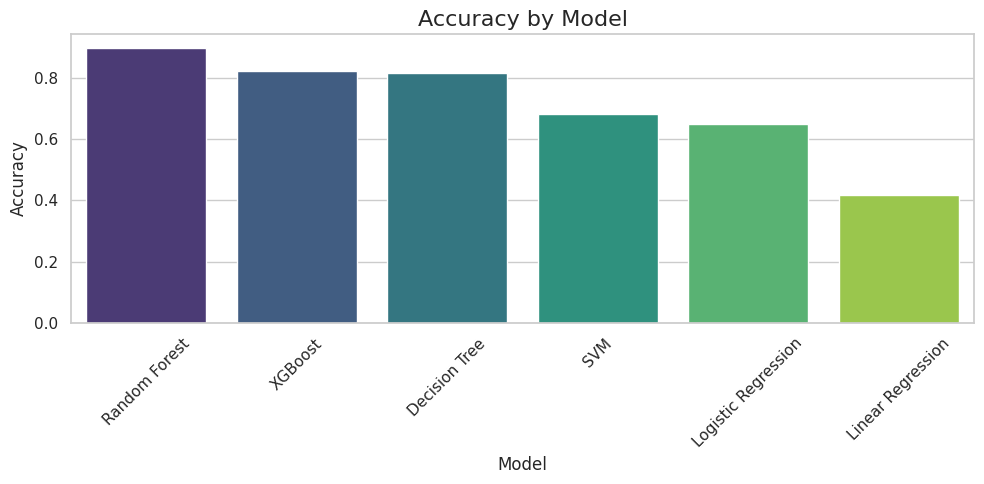

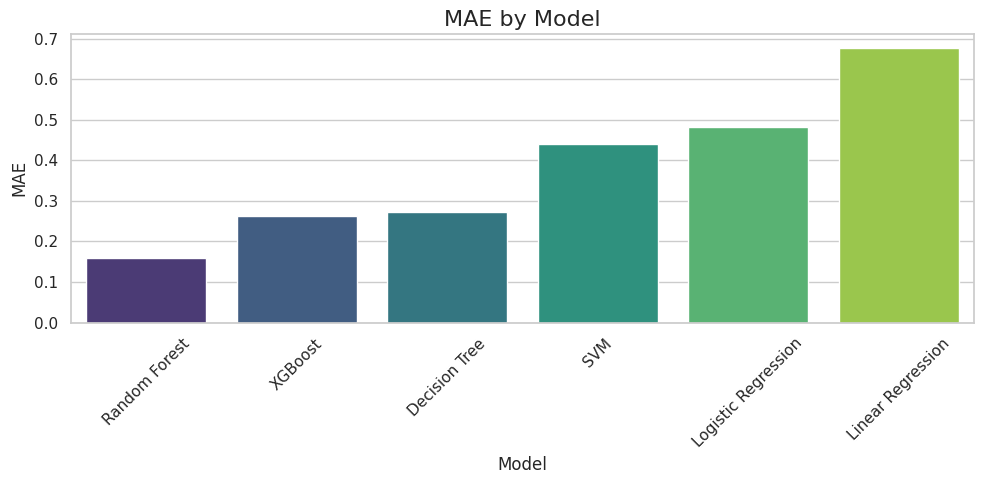

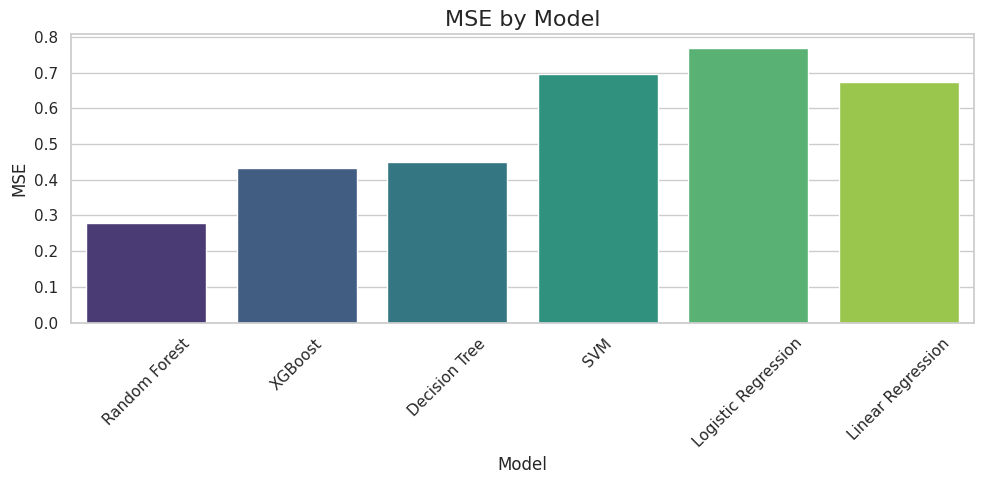

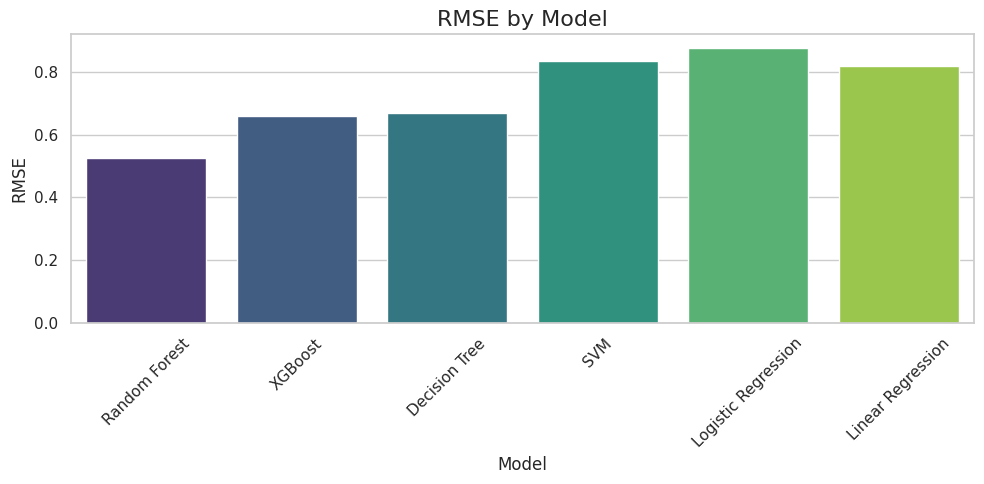

In [60]:
#plot evaluation
# set plot
sns.set(style="whitegrid")
metrics = ["Accuracy", "MAE", "MSE", "RMSE"]

# Plot each metric
for metric in metrics:
    plt.figure(figsize=(10, 5))
    sns.barplot(
        x=comparison_df.index,
        y=metric,
        data=comparison_df,
        palette="viridis"
    )
    plt.title(f"{metric} by Model", fontsize=16)
    plt.ylabel(metric)
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()